In [39]:
import os

import pandas
import numpy
import scipy.signal

import seaborn
from matplotlib import pyplot as plt

In [18]:

def load_dataset(path):
    data_columns = ['idx', 'x', 'y', 'z', 'label']
    samplerate = 52.0 # hz
    labels = {
        0: 'unknown',
        1: 'working',
        2: 'standing_up_walking_going_up_down_stairs',
        3: 'standing',
        4: 'walking',
        5: 'stairs',
        6: 'walking_talking',
        7: 'standing_talking',
    }
    
    parts = []
    
    for name in os.listdir(path):
        if not name.endswith('.csv'):
            continue
        filename = os.path.join(path, name)
        subject = name.replace('.csv', '')
        df = pandas.read_csv(filename, header=None, names=data_columns)
        df['subject'] = subject
        parts.append(df)

    out = pandas.concat(parts, ignore_index=True)
    # 
    out['label'] = out['label'].replace(labels).astype('category')
    # index by time
    out['time'] = out['idx'] * (1.0/samplerate)
    out = out.drop(columns=['idx'])
    out = out.set_index(['subject', 'time']).sort_index()
    return out

dataset_path = 'Activity Recognition from Single Chest-Mounted Accelerometer'
data = load_dataset(dataset_path)
print(data.shape)
data.head(1)

(1926896, 4)


,,x,y,z,label
subject,time,,,,
1,0.0,1502,2215,2153,working


```
33 minutes of walking up/down stairs
82 minutes of walking
115 minutes of talking
44 minutes of staying standing
86 minutes of working at computer
```

In [33]:
data.label.value_counts() / (52*60*2)

working                                     97.542788
standing_talking                            95.122276
walking                                     57.221795
standing                                    34.733494
stairs                                       8.252885
standing_up_walking_going_up_down_stairs     7.672756
walking_talking                              7.655449
unknown                                      0.595994
Name: label, dtype: float64

In [36]:
# same as in the paper
# FIXME: verify this mapping
cleaned = data.copy()
cleaned['label'] = cleaned['label'].replace({'standing_talking': 'talking'})
enabled_classes = ['stairs', 'walking', 'talking', 'standing', 'working']

cleaned = cleaned[cleaned.label.isin(enabled_classes)]
cleaned.label.value_counts() / (52*60)

working                                     195.085577
talking                                     190.244551
walking                                     114.443590
standing                                     69.466987
stairs                                       16.505769
standing_up_walking_going_up_down_stairs      0.000000
unknown                                       0.000000
walking_talking                               0.000000
Name: label, dtype: float64

In [43]:
# Compute the overall accelerometer magnitude

def compute_magnitude(df, columns=['x', 'y', 'z'], axis=-1):
    vectors = df[columns]
    mag = numpy.linalg.norm(vectors, axis=axis)
    return mag

cleaned['m'] = compute_magnitude(cleaned)
cleaned


x     y     z    label            m
subject time                                               
1       0.000000     1502  2215  2153  working  3434.768988
        0.019231     1667  2072  2047  working  3355.932359
        0.038462     1611  1957  1906  working  3171.435952
        0.057692     1601  1939  1831  working  3110.543843
        0.076923     1643  1965  1879  working  3176.683018
...                   ...   ...   ...      ...          ...
9       3206.538462  2071  2549  2053  talking  3873.144846
        3206.538462  2072  2545  2059  talking  3874.234118
        3206.538462  2069  2547  2064  talking  3876.604958
        3206.538462  2069  2542  2062  talking  3872.256319
        3206.538462  2069  2543  2063  talking  3873.445366

[1827529 rows x 5 columns]

In [57]:
# Split into low (DC) and high frequency components (AC), with a filter at 1.0 Hz
def apply_filter(values, kind='highpass', cutoff=1.0, order=2, fs=52, axis=-1):
    sos = scipy.signal.iirfilter(N=order, Wn=cutoff, btype=kind, output='sos', fs=fs)
    y = scipy.signal.sosfilt(sos, x=values, axis=axis, zi=None)
    return y
    
def apply_filters(df, columns=['x', 'y', 'z', 'm'], kind='highpass'):
    out = df.copy()
    for c in columns:
        out[c] = apply_filter(out[c])
    return out

dc = cleaned.groupby('subject', group_keys=False).apply(apply_filters, kind='lowpass').add_prefix('dc_')
ac = cleaned.groupby('subject', group_keys=False).apply(apply_filters, kind='highpass').add_prefix('ac_')
merged = cleaned.add_prefix('b_')
merged = pandas.merge(merged, dc, right_index=True, left_index=True)
merged = pandas.merge(merged, ac, right_index=True, left_index=True)
merged

b_x   b_y   b_z  b_label          b_m         dc_x  \
subject time                                                               
1       0.000000     1502  2215  2153  working  3434.768988  1378.989880   
        0.019231     1667  2072  2047  working  3355.932359  1295.340264   
        0.038462     1611  1957  1906  working  3171.435952  1004.523936   
        0.057692     1601  1939  1831  working  3110.543843   788.122987   
        0.076923     1643  1965  1879  working  3176.683018   642.864895   
...                   ...   ...   ...      ...          ...          ...   
9       3206.538462  2069  2543  2063  talking  3873.445366    -0.983288   
        3206.538462  2069  2543  2063  talking  3873.445366    -0.983288   
        3206.538462  2069  2543  2063  talking  3873.445366    -0.983288   
        3206.538462  2069  2543  2063  talking  3873.445366    -0.983288   
        3206.538462  2069  2543  2063  talking  3873.445366    -0.983288   

                            dc_y         dc_z dc_label         dc_m  \
subject time                                                          
1       0.000000     2033.596927  1976.674575  working  3153.469823   
        0.019231     1555.552357  1542.305830  working  2543.380250   
        0.038462     1157.402339  1123.308726  working  1897.939610   
        0.057692      895.296312   815.627143  working  1441.861415   
        0.076923      702.727435   658.242169  working  1154.675896   
...                          ...          ...      ...          ...   
9       3206.538462    -1.513739     1.637608  talking    -0.649724   
        3206.538462    -1.513739     1.637608  talking    -0.649724   
        3206.538462    -1.513739     1.637608  talking    -0.649724   
        3206.538462    -1.513739     1.637608  talking    -0.649724   
        3206.538462    -1.513739     1.637608  talking    -0.649724   

                            ac_x         ac_y         ac_z ac_label  \
subject time                                                          
1       0.000000     1378.989880  2033.596927  1976.674575  working   
        0.019231     1295.340264  1555.552357  1542.305830  working   
        0.038462     1004.523936  1157.402339  1123.308726  working   
        0.057692      788.122987   895.296312   815.627143  working   
        0.076923      642.864895   702.727435   658.242169  working   
...                          ...          ...          ...      ...   
9       3206.538462    -0.274480     6.584028    -8.413085  talking   
        3206.538462     0.853693     1.592069    -1.585377  talking   
        3206.538462    -1.879225     2.871452     3.273058  talking   
        3206.538462    -1.403307    -2.515427     0.897650  talking   
        3206.538462    -0.983288    -1.513739     1.637608  talking   

                            ac_m  
subject time                      
1       0.000000     3153.469823  
        0.019231     2543.380250  
        0.038462     1897.939610  
        0.057692     1441.861415  
        0.076923     1154.675896  
...                          ...  
9       3206.538462    -0.292615  
        3206.538462     0.654319  
        3206.538462     2.620331  
        3206.538462    -1.926852  
        3206.538462    -0.649724  

[46802209 rows x 15 columns]

/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


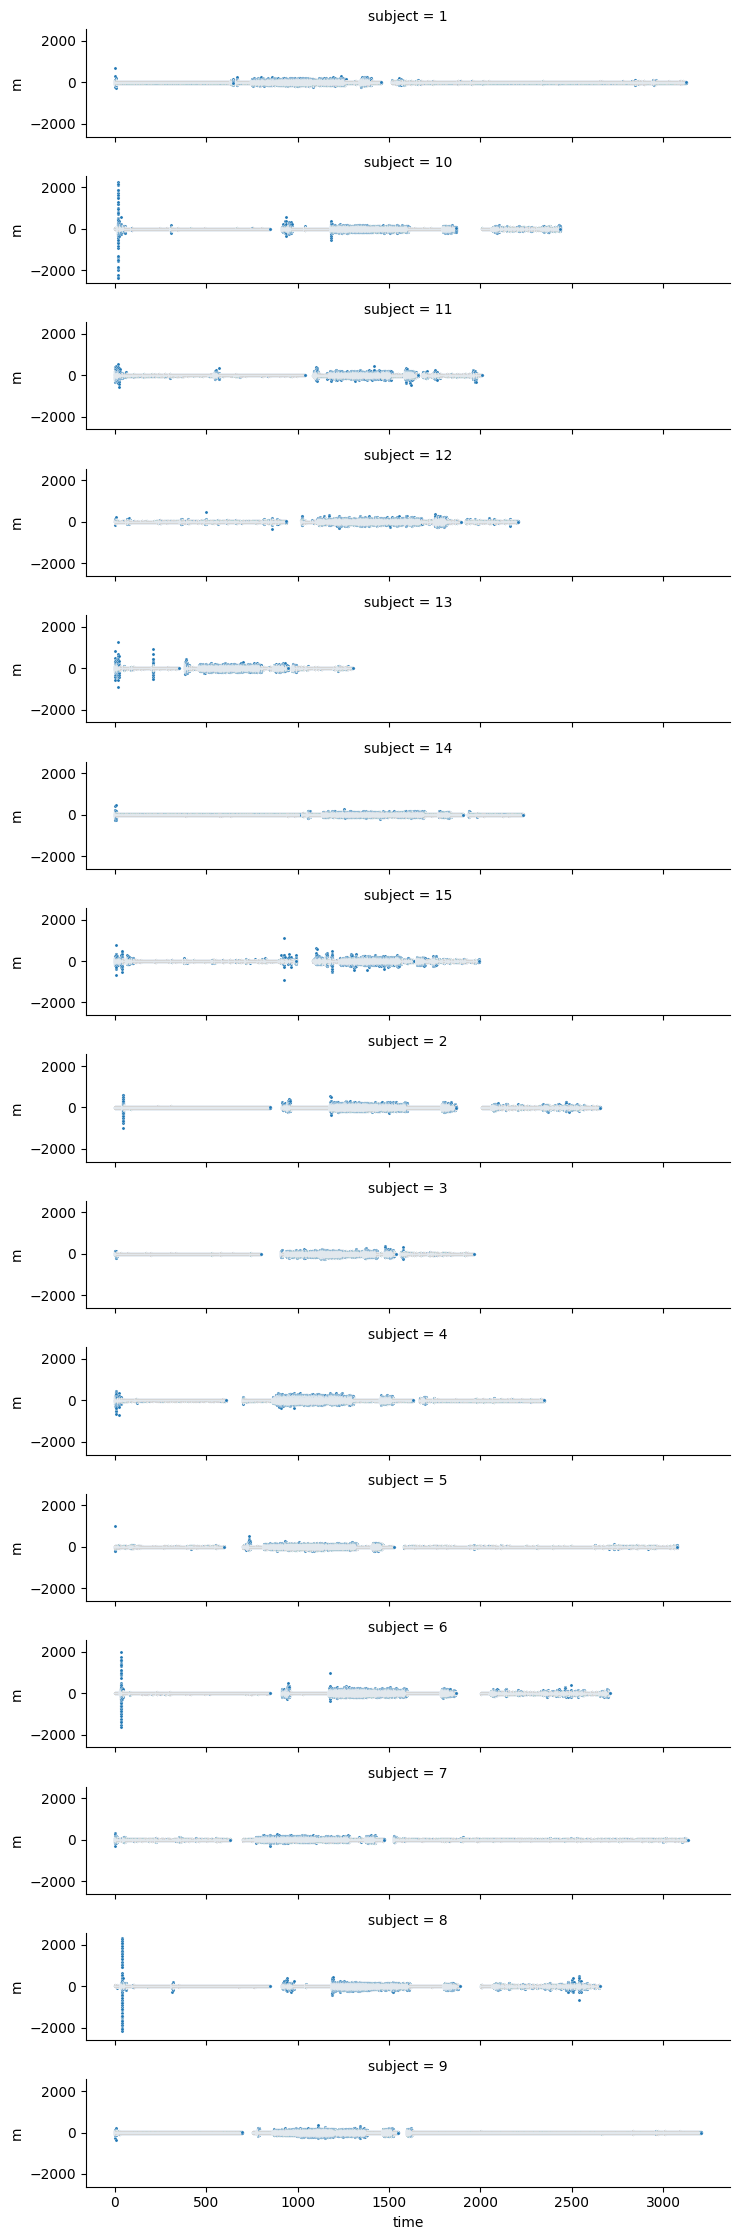

In [53]:

p = passed.reset_index()
p = p[p['time'] > 1.0]
seaborn.relplot(data=p, row='subject', y='m', x='time', height=1.5, aspect=5, s=5.0)

# TODO: plot X,Y,Z
# TODO: plot labeled as hspan sections


In [ ]:
 
# TODO: split into 1 second windows with 50% overlap

# https://numpy.org/devdocs/reference/generated/numpy.lib.stride_tricks.sliding_window_view.html



In [ ]:
# TODO: compute features for the time windows

20 features used in paper
```
RMS Velocity: Aydc, Azdc, Axac, Azb, Axdc, Amdc
Mean Value: Azb, Axdc, Amdc, Ayb, Azdc, Aydc
MinMax: Azdc, Axdc, Aydc, Azb, Amdc, Ayb
Standard Deviation: Axb, Axdc
```

# TODO: visualize based on the features

# MAYBE: try to implement their transformations of velocity RMS and minmax sums


In [49]:

# Setup evaluation
# 5-fold cross evaluation of instances
# FIXME: use windows with features

from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(n_estimators=10, min_samples_leaf=0.01)

features = ['x', 'y', 'z']
X = passed[features]
Y = passed['label']
cross_val_score(estimator, X, Y, cv=2, scoring='accuracy')


array([0.52915246, 0.54594184])

In [ ]:
# TODO: setup evaluation respecting subject